# COMP3314 Programming Assignment 2

## Due: May 4th , 2023 at 6:00 a.m.

Welcome to our last programming assignment! In this assignment, you will use **pure NumPy** to implement K-means clustering for handwritten digits (with MNIST dataset). Here are 3 programming tasks in total and all the parts you need to code are wrapped by comments like

```python
"""def some_func():
    ...
    ######## your code starts here ########


    ######## your code ends here   ########
    ...."""
```


1.   In this assignment, we will only use [NumPy](https://numpy.org/install/) and other built-in math libraries to implement those algorithms, unless specified otherwise. Note that PyTorch is not used in this assignment as we are not dealing with gradient backpropagation and no neural networks are involved. In this time, you will also see the high-degree similarity between PyTorch and NumPy APIs.

2.   We recommend you to use [Colab](https://colab.research.google.com/) for this programming assignment, since the provided assignment notebooks have been well tested on Colab. Nevertheless, it is definitely OK to use your own native environment, which requires installing [NumPy](https://numpy.org/install/).

3.   If you have issues about downoloading the notebook, try to
`open the course website in your browser -> right-click the assignment link -> save link as -> name this file -> click save`.
4.   To setup the Colab environment, you need to open https://colab.research.google.com/ and click `File -> Open notebook -> upload the provided notebook file`. There are many online [tutorials](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) for Colab, which you could refer to for reference.
5.   You do not need to write a report; just write codes, add text blocks and code comments in the colab notebook appropriately. Submit your notebook in `.ipynb` format to moodle, along with generated outputs of all code blocks. To export your notebook in Colab, simply click `File -> Download -> Download .ipynb` on your Colab tab. Late submissions will not be graded.

Have fun with this notebook!

In [2]:
import random

# Basic setup
import torch  
import numpy as np
import torchvision  
import torchvision.transforms as transforms  
from torch.autograd import Variable  
import matplotlib.pyplot as plt  
from tqdm.notebook import tqdm

# Task: clustering MNIST handwritten digits with K-means
This programming assignment requires you to define a K-means model, fit it to handwritten digit images and evaluate the performance. The K-means algorithm should be implemented with PyTorch and gradient descent. The dataset we employ here is the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which consists of handwritten digits of resolution 28 * 28 and their corresponding labels.

The code block below loads the dataset and visualizes some statistics. Note that in this task we only deal with the first 10000 samples of MNIST images in the train set.

In [3]:
def load_mnist(train, batch_size=1000):  # train = True or False, depending on whether you want to load the training or test set
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
    dataset = torchvision.datasets.MNIST(root='./data', train=train , download=True, transform=transform)
    dataset.data = dataset.data[:10000]  
    dataset.targets = dataset.targets[:10000]
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) 
    return data_loader

100%|██████████| 9912422/9912422 [00:00<00:00, 351253009.74it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26758492.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 174913159.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16268598.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Images have shape : torch.Size([1000, 784]), Labels have shape : torch.Size([1000])
Maximum pixel values : 1.0, minimum pixel values : -1.0


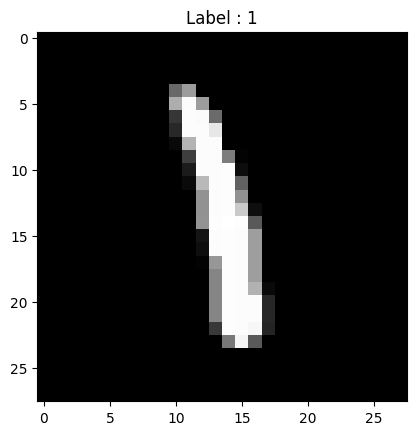

In [4]:
train_dataloader = load_mnist(train=True)
train_images, train_labels = next(iter(train_dataloader)) # load one batch of images and labels
train_images = train_images.view(-1, 28*28) 

# print some stats
print("Images have shape : {}, Labels have shape : {}".format(train_images.shape, train_labels.shape))
print("Maximum pixel values : {}, minimum pixel values : {}".format(torch.amax(train_images), torch.amin(train_images)))

# plot some digits
_image = train_images[0]
_label = train_labels[0]
plt.imshow(_image.reshape(28, 28), cmap='gray')
plt.title("Label : {}".format(_label))
plt.show()

## Task 1: One-hot encodings (10 points). 
In this task, we convert integer-valued labels to its **one-hot encodings**. Suppose the total number of classes is $C$. The one-hot representation of some label with value $c$ is a $C$-dimensional vector, whose entries are all 0 except for the $c$-th element. 

It is called one-hot since intuitively it turns “on” the $c$-th element of the vector, and leaves the other elements “off” (Page 174, [Textbook](https://probml.github.io/pml-book/book1.html)).

    Example: If the total number of classes is 10, then each one-hot vector is 10-dimensional.
    class 1  -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    class 10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

**Question**: 
1. Implement two functions `label_to_onehot()` and `onehot_to_label()`, where the first function transforms an array of labels to a matrix of one-hot encodings, and the second function does the reverse.


In [5]:
def label_to_onehot(labels):
    """
    Convert integer-valued labels to one-hot encodings.
    You can assume the total number of classes C = 10.

    labels: labels.shape == [N], where N is the number of data points.

    return
    onehot_vectors: 
        with shape [N, C], with each row represents 
        a one-hot vector of the corresponding label.
    """
    #### Your code starts here #####
    one_hotted = torch.zeros((len(labels), 10)).long()
    for i in range(len(labels)):
        one_hotted[i][labels[i]] = 1
    return one_hotted
    #### Your code ends here #####


def onehot_to_label(onehot_vectors):
    """
    Convert one-hot encodings to integer-valued labels.

    onehot_vectors: 
        with shape [N, C], with each row represents 
        a one-hot vector of the corresponding label.

    return
    labels: labels.shape == [N], where N is the number of data points.
    """
    #### Your code starts here #####
    labelled = torch.from_numpy(np.argmax(np.array(onehot_vectors), axis=1))
    return labelled  # are we gonna use pytorch or not anyway
    #### Your code ends here #####

In [6]:
# you can check the correctness by simply invoking
# np.allclose() functions compares two nd arrays in an element-wise way.
assert torch.allclose(train_labels, onehot_to_label(label_to_onehot(train_labels)))

In [7]:
# we need to transform the whole label set to its one-hot
# encodings for ease of subsequent computations.
train_labels = label_to_onehot(train_labels)
print(train_labels.shape)

torch.Size([1000, 10])


## Task 2: K-means (60 points)

In this task, you will implement a workable K-means clustering model to cluster MNIST handwritten digit images. K-means is a popular method to cluster (or partition) a set of $N$ data points into $K$ clusters, so that each data point belongs to the cluster with the nearest cluster center (or called **centroids**).

Technically, let us denote the $K$ clusters as $\boldsymbol{\mu}_1,\dots,\boldsymbol{\mu}_K \in \mathbb{R}^D$, the set of $N$ datapoints as $\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_N \in \mathbb{R}^D$. To cluster the data such that each data point is assigned to its closest centroid, the process can be written as a optimization problem:
                    $$ \min_{\mu_1,\mu_2, \dots \mu_k} \sum_{n=1}^N \frac{1}{N}(x_n - z_n)^2, \quad z_n=\arg \min _{k}\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right\|_{2}^{2}$$

The K-means algorithm is a simple and intuitive way to perform optimization. However, K-means algorithm tends to converge slowly when the dataset size is large or when the data is high dimensinal. In this assigment, we will explore gradient descent optimization to scale the K-Means algorithm for large datasets. The methods is as follows: 

1. Randomly initialize the cluster centroids $\boldsymbol{\mu}_k$ for each $k=1,2,\dots,K$;
2. For each data point $\boldsymbol{x}_n$ with $n = 1,2,\dots,N$, compute the index $z_n$ of its closest centroid,
$$z_{n}=\arg \min _{k}\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right\|_{2}^{2};$$
3. Calculate the cost function (distortion) for optimization. $$J(\mu) = \sum_{n=1}^N \frac{1}{N}(x_n - z_n)^2$$
4. Perform backward optimization for centroids and update the new cluster centroids.
    $$\boldsymbol{\mu}_{k}^{\text{new}} \gets  \boldsymbol{\mu}_{k} - \rho \nabla_{\mu_k}J(\mu), \quad k = 1,2,\dots,K.$$

5. Compare the old and new cluster centroids and if their difference is small enough (say less than 1e-8), then the algorithm has converged and terminates; otherwise, return to step **2** and iterate over the entire data set. 

**Note**: Sometimes, some cluster $k$ might receive no assigned data points. In this case, we just copy the old centroid value, $\boldsymbol{\mu}_{k}^{\text{new}}\gets \boldsymbol{\mu}_{k}$. 

Reference for this algorithm could be found in this paper [Bottou and Bengio, 1995](http://www.iro.umontreal.ca/~lisa/pointeurs/kmeans-nips7.pdf).

### Task 2.1 Initialization (10 points)
K-means is known to be very sensitive to initializations of cluster centroids; here we discuss three different strategies to perform initializations.
- `random`: initialize cluster centroids as random values at $[-1,1]$, which is the minimum and maximum value of our image data respectively;
- `kmeans`: pick $K$ data points from the data set at random, and use these as the initial values for $\{\boldsymbol{\mu}_{k}\}_{k=1}^K$.

**Questions**:
1. Implement these 2 strategies in the `init_centroids()` member function, where
    - 5 points for `random`, 
    - 5 points for `kmeans`. 


### Task 2.2 Implement K-means with Gradient Descent iteration step (32 points)

Suppose the centroids have been initialized. Given a set of data $\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_N \in \mathbb{R}^D$,

**Questions**:
1. (18 points) Implement the K-means algorithm (**step 2 - 4**) in the `fit()` member function below.

### Task 2.3 Evaluation metrics (12 points)

There are various ways to evaluate whether a clustering algorithm is good or not. In this assignment, we consider two metrics:
- **Purity** measures the extent to which clusters contain a *single* class. Technically, it is defined as (See our lecture [slide](https://nlp.cs.hku.hk/comp3314/14.pdf) or Textbook (Section 21.1.1) for more details)
$$\text{purity} = \sum_{k=1}^K \frac{N_k}{N}p_k,\quad\quad p_k = \max_c \frac{N_{ck}}{N_k},$$
where 
    - $N$ is the total number of data points, 
    - $N_k$ is the total number of data points in cluster $k$, and
    - $N_{ck}$ is the number of data points in cluster $k$ that belong to class $c$.

- **Distortion** measures how individual data points deviate from their assigned cluster centroids. It is just the mean of the squared distance between each data point and its assigned centroid,
$$J=\frac{1}{N}\sum_{n=1}^{N}\left\|\boldsymbol{x}_{n}-\boldsymbol{\mu}_{z_{n}}\right\|^{2}.$$

**Questions**:
1. (6 points) Compute visualize the purity for the new cluster centroids at each step in the `fit()` member function below (step 5). Visualize with a line plot.
2. (6 points) Compute the distortion at each step in the `fit()` member function below (step 5). Visualize with a line plot. 

**Note**: you are free to modify other parts of the class object as long as the member function signature remains the same.

In [8]:
class Kmeans(object):
    def __init__(self, num_clusters, cluster_dim, max_iterations=1000, lr=0.01):
        super().__init__()
        self.num_clusters = num_clusters
        self.cluster_dim = cluster_dim
        self.max_iterations = max_iterations
        self.lr = lr # threshold to check convergence
        self.centroids = None

        self.optimizer = None

    def init_centroids(self, input_x, method, optimizer='SGD'):
        """ Task 2.1
        Initialize k-means centroids.

        input_x: shape == [N, d], where 
            N is the number of data points and 
            d is the dimensionality of each data point.

        method: str. Possible values: ['random', 'kmeans']

        the initialized centroids must be stored as self.centroids.
        Let K be the number of clusters. self.centroids must be either 
            (1) a 2D ndarray with shape [K, d], or
            (2) a list of K numpy vectors with shape [d].
        """
        N,d = input_x.shape
        
        if method == 'random':
            ########## Task 2.1 ############
            #### Your code starts here #####
            centroids = torch.from_numpy(np.random.rand(self.num_clusters, self.cluster_dim) * 2 - 1).float()

            #### Your code ends here #####
        elif method == 'kmeans':
            ########## Task 2.1 ############
            #### Your code starts here #####
            indexes = list(np.random.choice(input_x.shape[0], self.num_clusters, replace=False))
            centroids = input_x[indexes].float()

            #### Your code ends here #####
        else:
            raise NotImplementedError("method {} is not supported!".format(method))

        # print(centroids)

        self.centroids = Variable(centroids, requires_grad=True)
        if optimizer == 'SGD':
            self.optimizer = torch.optim.SGD([self.centroids], lr=self.lr)
        elif optimizer == 'Adam':
            self.optimizer = torch.optim.Adam([self.centroids], lr=self.lr)
        else: # AdamW
            self.optimizer = torch.optim.AdamW([self.centroids], lr=self.lr, weight_decay=0.01)
        assert self.centroids is not None
    
    def calculate_distortion(self, input_x, cluster_assignments):
        """
        Returns the computed distortion for all clusters.

        input_x: shape == [N, d], where 
            N is the number of data points and 
            d is the dimensionality of each data point.

        z: shape == [N], stores the closest centroid index for each data point.

        return
        distortion: a scalar.
        
        """
        
        distortion = torch.mean(torch.norm(input_x - self.centroids[cluster_assignments], dim=-1) ** 2, dim=0)
        
        return distortion

    def calculate_purity(self, labels_in_clusters):
        """
    `    Returns the computed purity for all clusters.

        labels_in_clusters: shape == [K, C], where 
            K is the number of clusters and 
            C is the number of data classes.

        return
        purity: a scalar.
        """
        
        total_num = torch.sum(labels_in_clusters, dim=-1) # [c]
        labels_in_clusters = torch.clamp(labels_in_clusters, min=1e-20)
        p = labels_in_clusters / (torch.sum(labels_in_clusters, dim=-1, keepdim=True))
        p = torch.amax(p, dim=-1) # [c]
        purity = torch.sum(p * total_num / torch.sum(total_num))
        
        return purity

    def fit(self, input_dataloader):
        """ Task 2.2 & 2.3
        Do the K-means clustering step with gradient descent.

        input_x: shape == [N, d], where 
            N is the number of data points and 
            d is the dimensionality of each data point.

        input_y: shape == [N, C], where
            K is the number of clusters and 
            C is the number of classes.
        
        *Note that input_y are label one-hot encodings.
        *During clustering, we do not use the label information; input_y is passed
        for you to compute the purity of the formed clusters.

        """
        distortion_history = []  
        purity_history = []
        
        
        for _ in tqdm(range(self.max_iterations)):  
            
            avg_distortion = []
            avg_purity = []
                
            for input_x, input_y in input_dataloader:
                
                input_x = input_x.view(-1, 28*28) 
                # input_y = label_to_onehot(input_y) (redundant)
                N = input_y.shape[0]
                # C = input_y.shape[1]
            
            
                ########## Task 2.2 ############
                #### Your code starts here #####

                # step 2.

                # Compute distances from data points to centroids  
                distances = torch.sqrt(torch.sum(torch.square(torch.unsqueeze(input_x, 1) - self.centroids), dim=2))
                
                # step 3.
                # Assign each data point to the closest centroid  
                cluster_assignments = torch.argmin(distances, dim=1, keepdim=False)

                # step 4.
                # Update centroids using gradient descent  
                # Hint: you can use optimizer.step() and loss.backward() to update the centroids.
                loss = self.calculate_distortion(input_x, cluster_assignments)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
                # step 5. calculate and store distortion and purity
                avg_distortion.append(loss.detach().numpy())
                purity_input = torch.zeros(self.num_clusters, self.cluster_dim)
                # print(purity_input.shape)
                for i in range(input_y.shape[0]):
                    # print(cluster_assignments[i].item())
                    # print(input_y[i].item())
                    purity_input[cluster_assignments[i].item(), input_y[i].item()] += 1

                avg_purity.append(self.calculate_purity(purity_input))
            
                #### Your code ends here #####

            
            distortion_history.append(np.mean(avg_distortion))
            purity_history.append(np.mean(avg_purity))
        
        return distortion_history, purity_history
    


We provide additional functions for ease of visualization.

In [9]:
# Visualize clustered results  
def visualize(images, labels, centroids, cluster_assignments):  
    fig, axes = plt.subplots(10, 11, figsize=(15, 15))  
    for i in range(10):  
        axes[i, 0].imshow(centroids[i].reshape(28, 28).numpy(), cmap='gray')  
        axes[i, 0].set_title(f'Cluster {i+1}')  
        axes[i, 0].axis('off')  
  
        cluster_images = images[cluster_assignments == i][:10]  
        for j, img in enumerate(cluster_images):  
            axes[i, j+1].imshow(img.reshape(28, 28).numpy(), cmap='gray')  
            axes[i, j+1].axis('off')  
  
    plt.show()  
    
def visualize_attribute(attribute_history, name='Distortion'):  
    plt.plot(attribute_history)  
    plt.xlabel('Iteration')  
    plt.ylabel('Loss')  
    plt.title('K-means '+name)  
    plt.show() 
    
def vector_to_image_plots(input_vec, num_figures=1):
    # see the usage below.
    # given data with shape [28 * 28]
    input_vec=(input_vec.numpy() + 1)*255/2
    if isinstance(input_vec, list):
        input_vec = np.vstack(input_vec)
    num_vec = input_vec.shape[0]
    assert num_figures == num_vec
    new_shape = (num_figures, 28, 28)
    input_vec = input_vec.reshape(new_shape)
    input_vec = input_vec.astype(np.uint8)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    figs, axes = plt.subplots(nrows=1, ncols=num_figures)
    # figs.tight_layout()
    for n in range(num_figures):
            axes[n].set_axis_off()
            axes[n].imshow(input_vec[n], cmap='gray')
    plt.show()

If you implement K-means model properly, the following fitting script should work smoothly.

**Note**: In general, it is normal if you observe the distortion does not decrease or converges to a very large value; however, the purity (ranging from 0 to 1) should keep increasing and probably converge at around 0.500 ~ 0.700.

In [ ]:
# (result of this cell is stored in the file 'view_the_latest_result.ipynb'.)
# tune your hyperparameters here 
#################################################################################

# NOTE: the result takes huge space and is run separately to save time and there is no way to combine two different files, even there is, it is very inconvenient to check.
# thus the result of this cell is stored in the file 'view_the_latest_result.ipynb'.
# Therefore the origin output of this cell is erased.
# result of this cell is also used for question 3.1 and 3.2.

num_centroids = 10
num_classes = 10
cluster_dim = 784
max_iterationses = [10, 75, 150, 300, 500]
opts = ['SGD', 'Adam', 'AdamW']
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
init_methods = ['kmeans', 'random']
#################################################################################
for max_iterations in max_iterationses:
    for opt in opts:
        for lr in lrs:
            for init_method in init_methods:
                train_dataloader = load_mnist(True, batch_size=1000)
                test_dataloader = load_mnist(False , batch_size=1000)
                kmeans = Kmeans(num_centroids, cluster_dim, max_iterations=max_iterations, lr=lr)

                one_batch_x, _ = next(iter(train_dataloader))
                one_batch_x = one_batch_x.view(-1, 28*28)

                kmeans.init_centroids(one_batch_x, init_method, optimizer=opt)
                distortion_history, purity_history = kmeans.fit(train_dataloader)

                print('↓ max_ite='+str(max_iterations), '  optmzer='+opt, '  lr='+str(lr), '  init_mthd='+init_method)
                visualize_attribute(distortion_history, name="Distortion")
                visualize_attribute(purity_history, name="Purity")


# NOTE: the result takes huge space and is run separately to save time and there is no way to combine two different files, even there is, it is very inconvenient to check.
# thus the result of this cell is stored in the file 'view_the_latest_result.ipynb'.
# Therefore the origin output of this cell is erased.
# result of this cell is also used for question 3.1 and 3.2.

Visualize the clustered results.

  0%|          | 0/300 [00:00<?, ?it/s]

↓ max_ite=300   optmzer=Adam   lr=0.01   init_mthd=kmeans


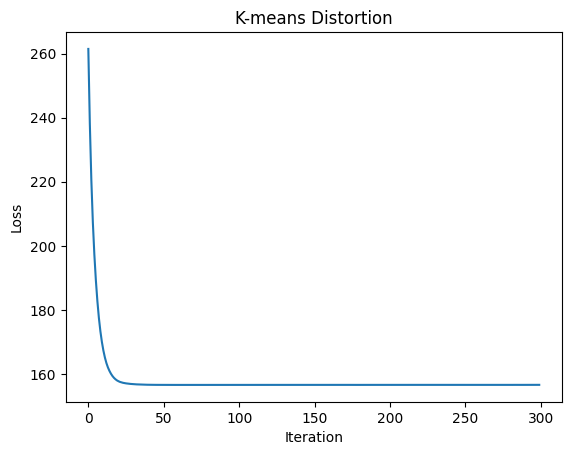

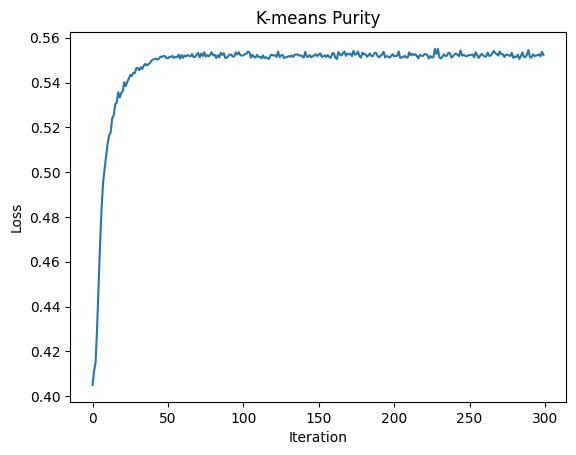

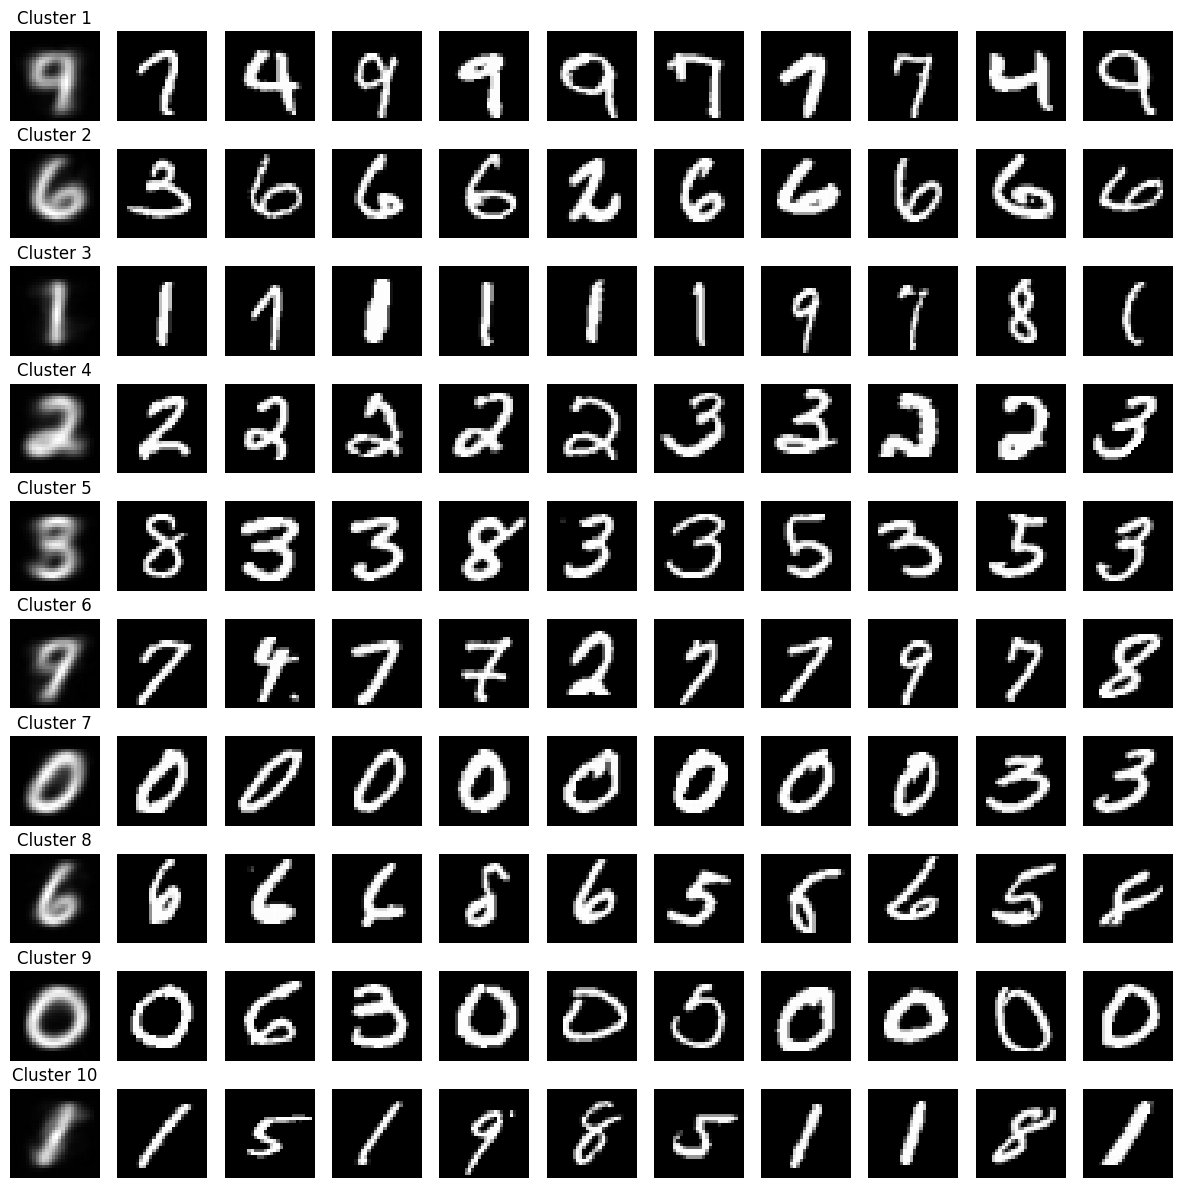

In [11]:
train_dataloader = load_mnist(True, batch_size=1000)
test_dataloader = load_mnist(False , batch_size=1000)

one_batch_x, _ = next(iter(train_dataloader))
one_batch_x = one_batch_x.view(-1, 28*28)

num_centroids = 10
num_classes = 10
cluster_dim = 784
max_iterations = 300
opt = 'Adam'
lr = 1e-2
init_method = 'kmeans'

temp = Kmeans(num_centroids, cluster_dim, max_iterations=max_iterations, lr=lr)
temp.init_centroids(one_batch_x, init_method, optimizer=opt)
distortion_history, purity_history = temp.fit(train_dataloader)

print('↓ max_ite='+str(max_iterations), '  optmzer='+opt, '  lr='+str(lr), '  init_mthd='+init_method)
visualize_attribute(distortion_history, name="Distortion")
visualize_attribute(purity_history, name="Purity")


centroids = temp.centroids.detach()

train_images, train_labels = next(iter(train_dataloader)) 
X_train = train_images.view(-1, 28*28) 
train_distances = torch.cdist(X_train, centroids)  
train_cluster_assignments = torch.argmin(train_distances, dim=1)  
visualize(train_images, train_labels, centroids, train_cluster_assignments)  


Visualize the shape of centroids with `vector_to_image_plots()`

<Figure size 640x480 with 0 Axes>

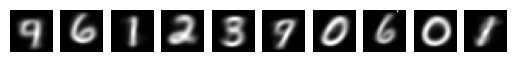

In [12]:
vector_to_image_plots(centroids, num_figures=10)

## Task 3: Evaluation (30 points).
In this section, you will evaluate your fitted K-means model at various aspects.

**Questions**:
1. (5 points) Tune the hyperparameters: maximum iterations, learning rate and optimizer(e.g. SGD, Adam, AdamW) to find the best combination. Discuss your hyperparameter tuning method.
2. (5 points) Compare the performance of two different initialization strategies in Task 2.1 and explain your findings.
3. (10 points) For `random` initialization strategy, compare the centroid shapes (plotted by `vector_to_image_plots()` function) **before** and **after** fitting. Briefly describe your observations.
4. (10 points) We know the actual number of clusters for our case is 10, since the data comes from 10 classes. Nevertheless, as there exist natural similarities between different digits (e.g., `1` and `7`, `8` and `3`, etc.), try to vary the number of clusters between 3, 10, 15, 20, 100, and 
    1. (5 points) Plot the **distortion** and  **purity** curves versus the number of iterations under different numbers of clusters.
    2. (5 points) Normally, you would observe **distortion** and  **purity** just keeps decreasing and increasing respectively as the number of clusters increases, although the `oracle` is to maintain 10 clusters. Explain why this is the case.
    
    
**Hint**: as pointed out in our textbook, we can trivially achieve a purity of 1 by putting each object into its own cluster; hence these two are generally not a perfect metric for evaluating clustering methods.


# Ans: Task 3.1 and 3.2
## 3.1
After tuning, the best combination could be: **{max_ite: 300; lr: 1e-2; optimizer: Adam}**. The result might be sensitive to initialization result, and different (max_ite, lr) pairs within some range might all generate relatively decent result, however after several trial, {max_ite: 300; lr: 1e-2; optimizer: Adam} generally generates the best result I believe.

My tuning strategy is: first fix the optimizer, then find the best combination of max_ite and lr. Generally less iteration needs larger learning rate, but going to extreme would lead to under-fitting, while we also want a decent value of max_ite to avoid unnecessarily huge demand of computational power. This is the basic idea.

Also, I tried another strategy which is simple and brute, that is running every combination of these hyperparameters and also init_methods (or in short, grid search). The result is given below and this leads to the same result.

## 3.2
No matter partially focus on the chosen combination or take an overview of the complete result, it suffices to say that **'kmeans' outperforms 'random' regarding initialization methods.**

## Note: For the graphs and pictures, please refer to the 'view_the_result' file.

## Ans: Task 3.3
code is shown below

<Figure size 640x480 with 0 Axes>

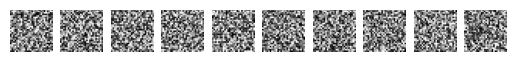

  0%|          | 0/300 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

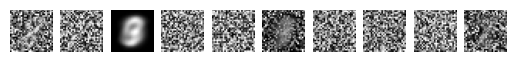

↓ max_ite=300   optmzer=Adam   lr=0.01   init_mthd=random


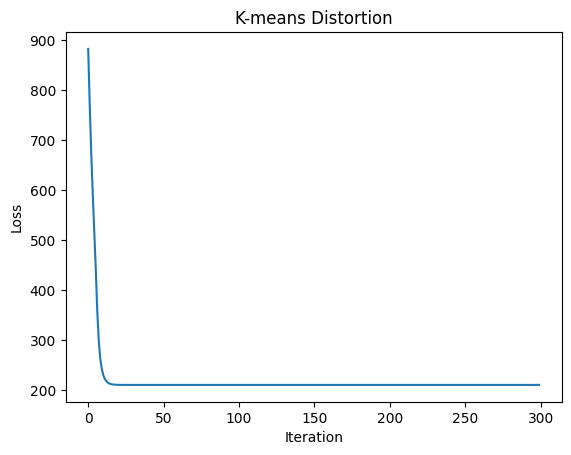

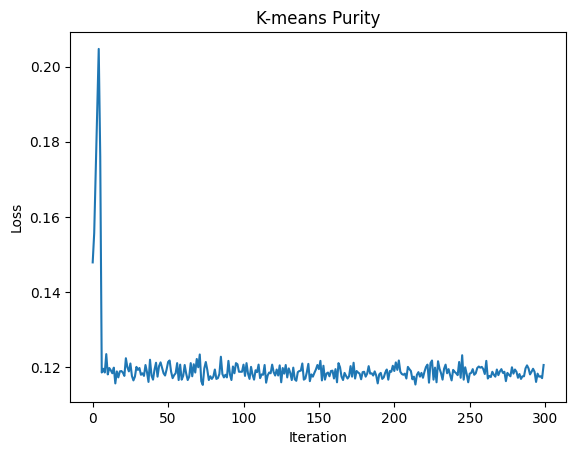

In [13]:
# code for task 3.3

# naming like this because hyperparameter choice is based on the best combination in task 3.1, except for initialization method.
best_num_centroids = 10
best_num_classes = 10
best_cluster_dim = 784
best_max_iterations = 300
best_opt = 'Adam'
best_lr = 1e-2
best_init_method = 'random'

best_train_dataloader = load_mnist(True, batch_size=1000)
best_test_dataloader = load_mnist(False , batch_size=1000)
best_kmeans = Kmeans(best_num_centroids, best_cluster_dim, max_iterations=best_max_iterations, lr=best_lr)

best_one_batch_x, _ = next(iter(best_train_dataloader))
best_one_batch_x = best_one_batch_x.view(-1, 28*28)

best_kmeans.init_centroids(best_one_batch_x, best_init_method, optimizer=best_opt)
vector_to_image_plots(best_kmeans.centroids.detach(), num_figures=best_kmeans.num_clusters)
best_distortion_history, best_purity_history = best_kmeans.fit(best_train_dataloader)
vector_to_image_plots(best_kmeans.centroids.detach(), num_figures=best_kmeans.num_clusters)

print('↓ max_ite='+str(best_max_iterations), '  optmzer='+best_opt, '  lr='+str(best_lr), '  init_mthd='+best_init_method)
visualize_attribute(best_distortion_history, name="Distortion")
visualize_attribute(best_purity_history, name="Purity")


### Answer and explanation:
Using 'random' as initialization method, we can see that centroids' shapes are just noise and full of 'snowflakes' before fitting (which is reasonable because pixel values are pure random values in [1, -1]). After fitting, only one of the shapes seems not meaningless, and this one looks like the overlapping result of all the 10 digits and corresponds to the class which all the data are classified into. 

My understanding is that the number of 'not pure noise' centroids doesn'y always has to be 1 and may be sensitive to initialization, and that the reason for this phenomenon is that random initialization method tend to regard every pixel the same and thus 'embed' info of all digits 'equivalently', which leads to a bad and undistingushable initialization result and consequently classify 'similar' (sometimes even being 'all') digits into one class.

result backup:
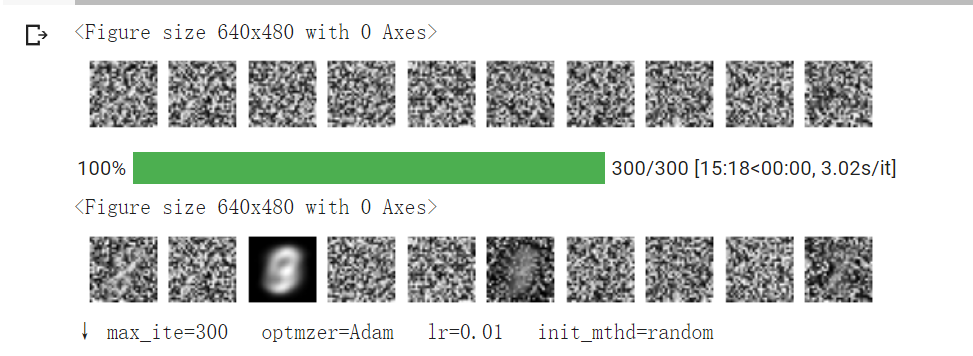




# Ans: Task 3.4(1)
code is shown below.

  0%|          | 0/300 [00:00<?, ?it/s]

↓ num of centroids: 3


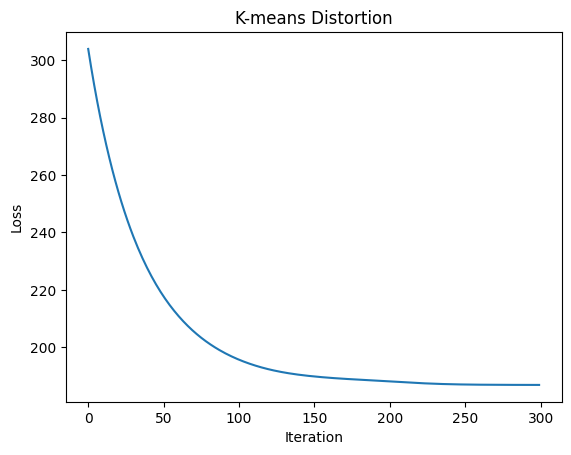

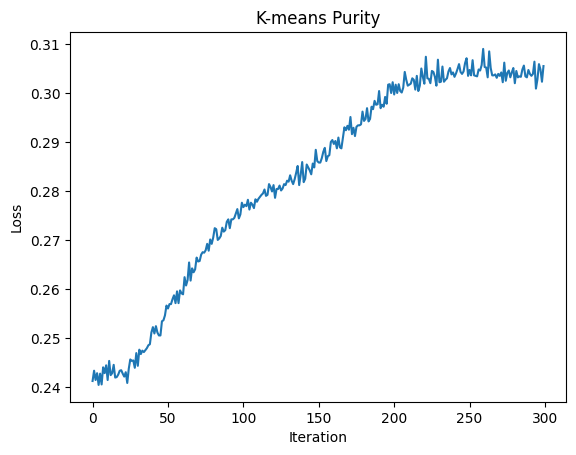

  0%|          | 0/300 [00:00<?, ?it/s]

↓ num of centroids: 10


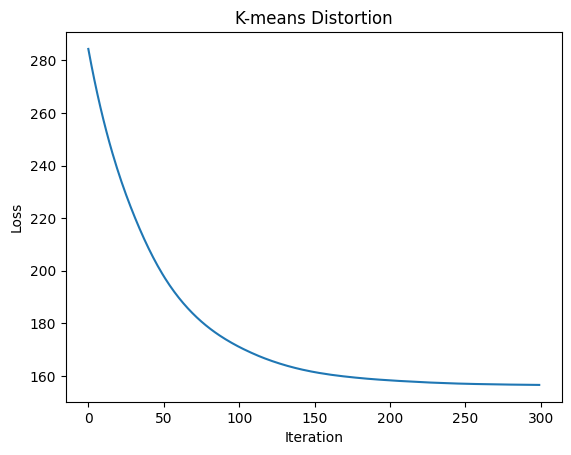

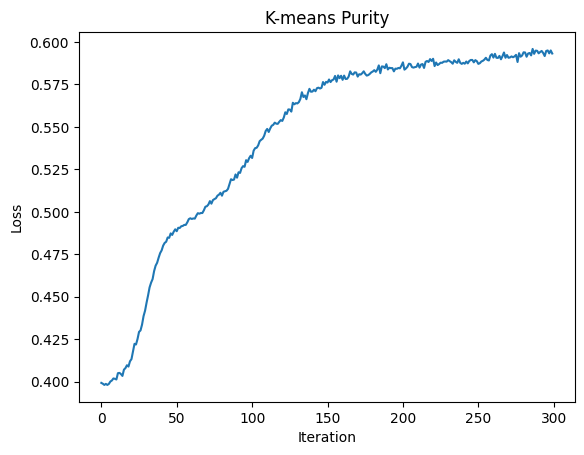

  0%|          | 0/300 [00:00<?, ?it/s]

↓ num of centroids: 15


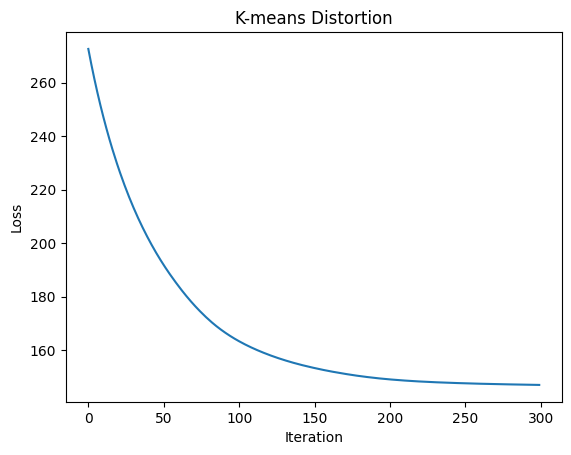

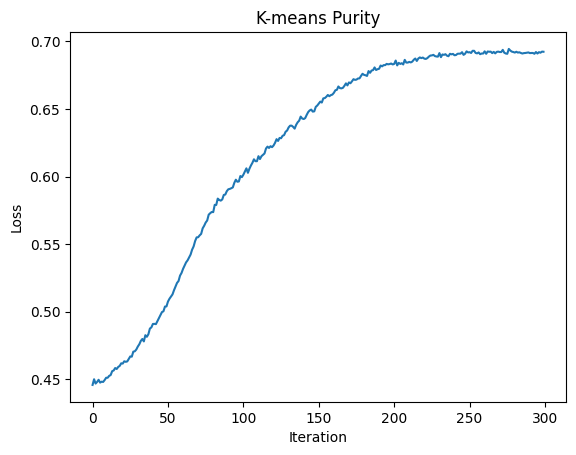

  0%|          | 0/300 [00:00<?, ?it/s]

↓ num of centroids: 20


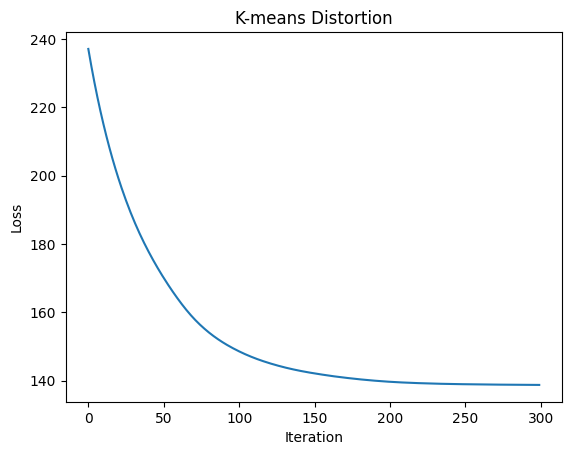

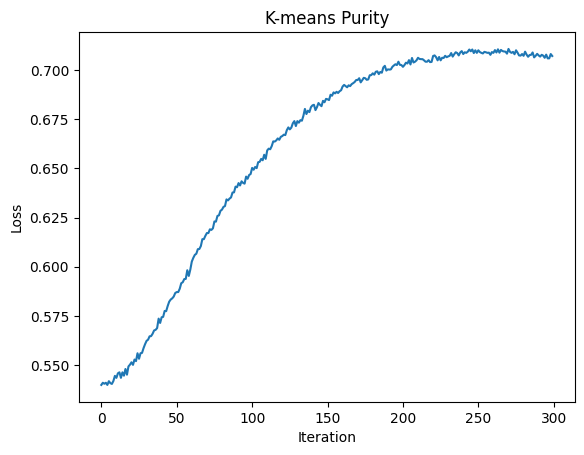

  0%|          | 0/300 [00:00<?, ?it/s]

↓ num of centroids: 100


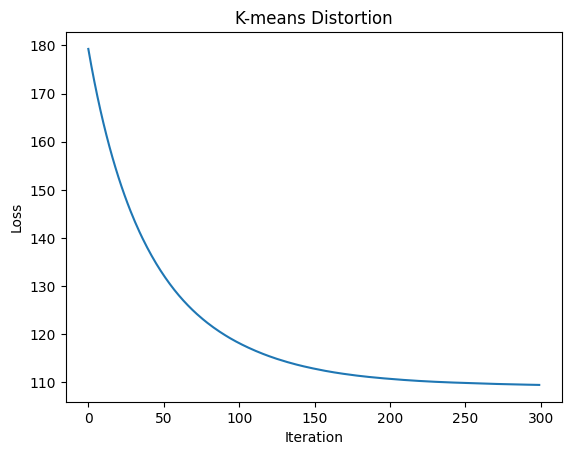

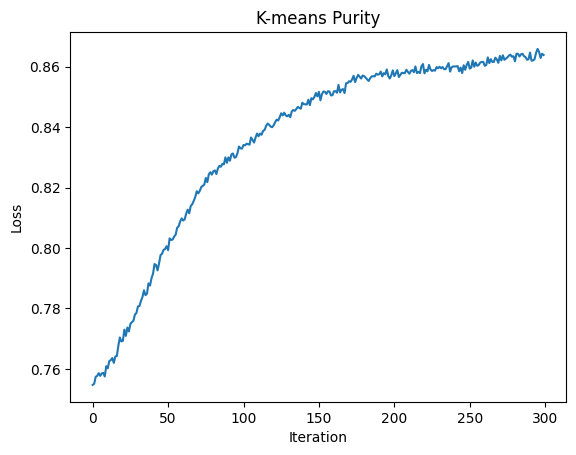

In [ ]:
# naming like this because hyperparameter choice is based on the best combination in task 3.1, except for max_iteration.
best_num_centroidses = [3, 10, 15, 20, 100]
best_num_classes = 10
best_max_iterations = 300
best_opt = 'Adam'
best_lr = 1e-2
best_init_method = 'kmeans'

for best_num_centroids in best_num_centroidses:
    best_train_dataloader = load_mnist(True, batch_size=1000)
    best_test_dataloader = load_mnist(False , batch_size=1000)
    best_kmeans = Kmeans(best_num_centroids, best_cluster_dim, max_iterations=best_max_iterations, lr=best_lr)

    best_one_batch_x, _ = next(iter(best_train_dataloader))
    best_one_batch_x = best_one_batch_x.view(-1, 28*28)

    best_kmeans.init_centroids(best_one_batch_x, best_init_method, optimizer=best_opt)
    best_distortion_history, best_purity_history = best_kmeans.fit(best_train_dataloader)

    print('↓ num of centroids: '+str(best_num_centroids))
    visualize_attribute(best_distortion_history, name="Distortion")
    visualize_attribute(best_purity_history, name="Purity")

# results backup:






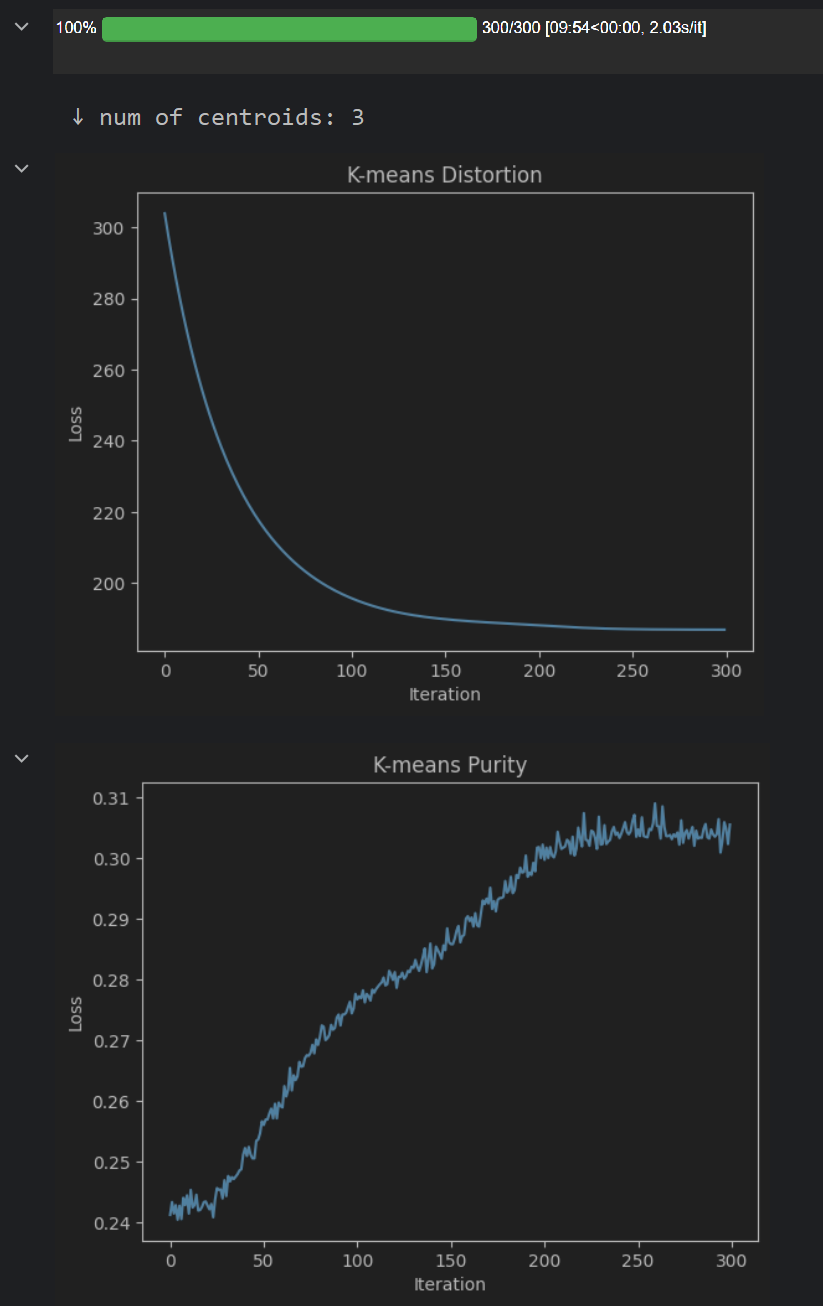

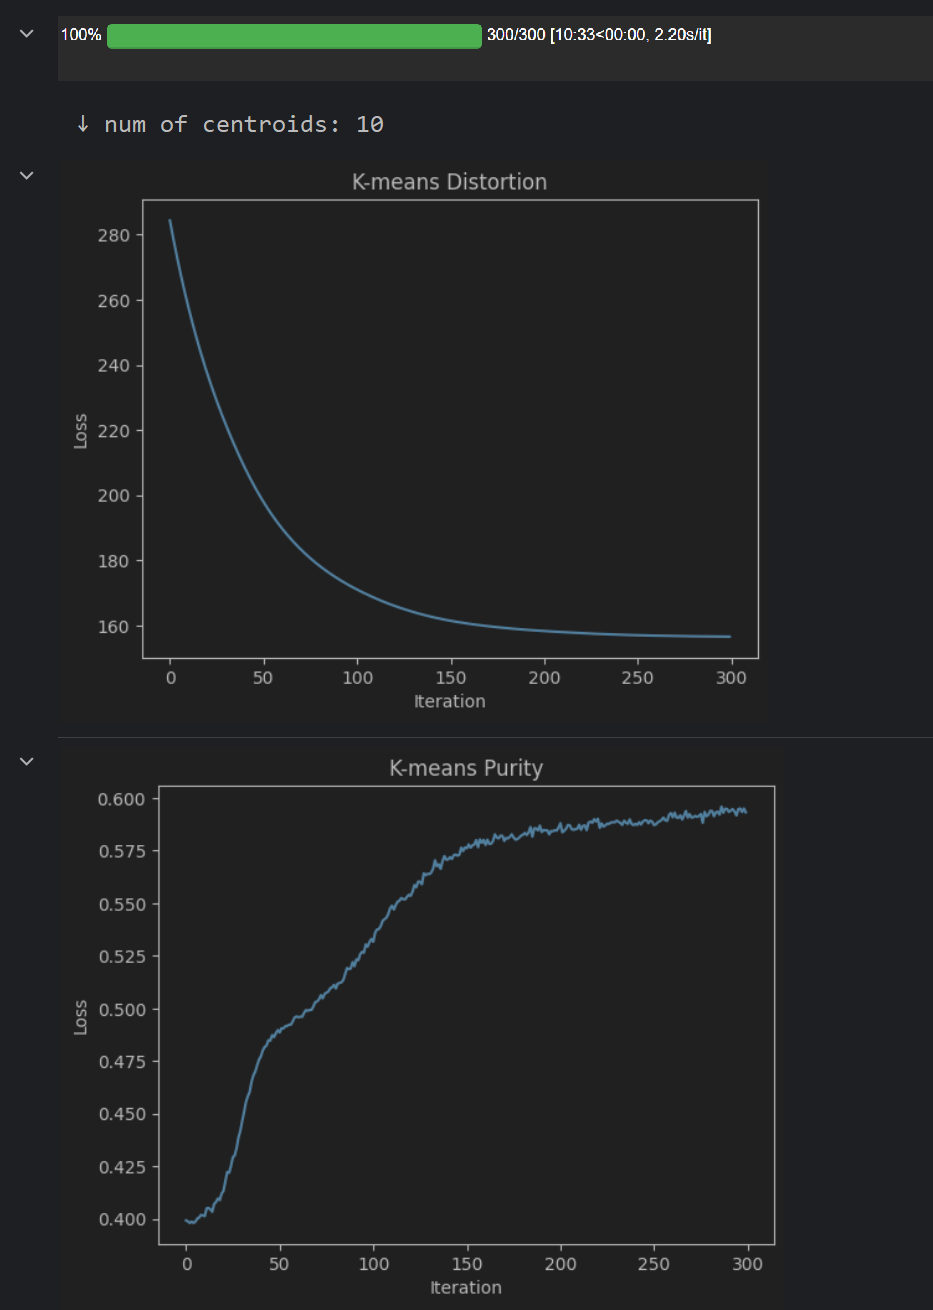

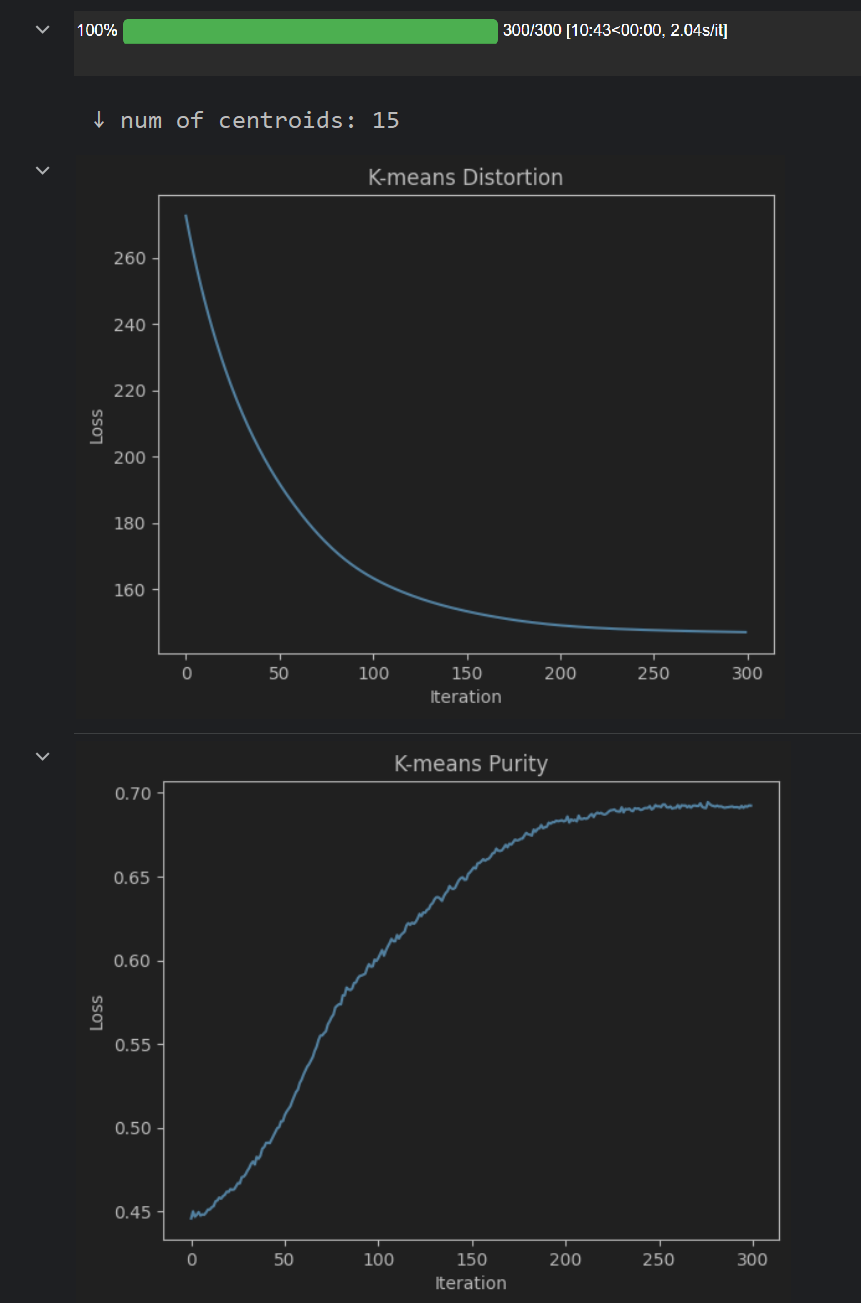

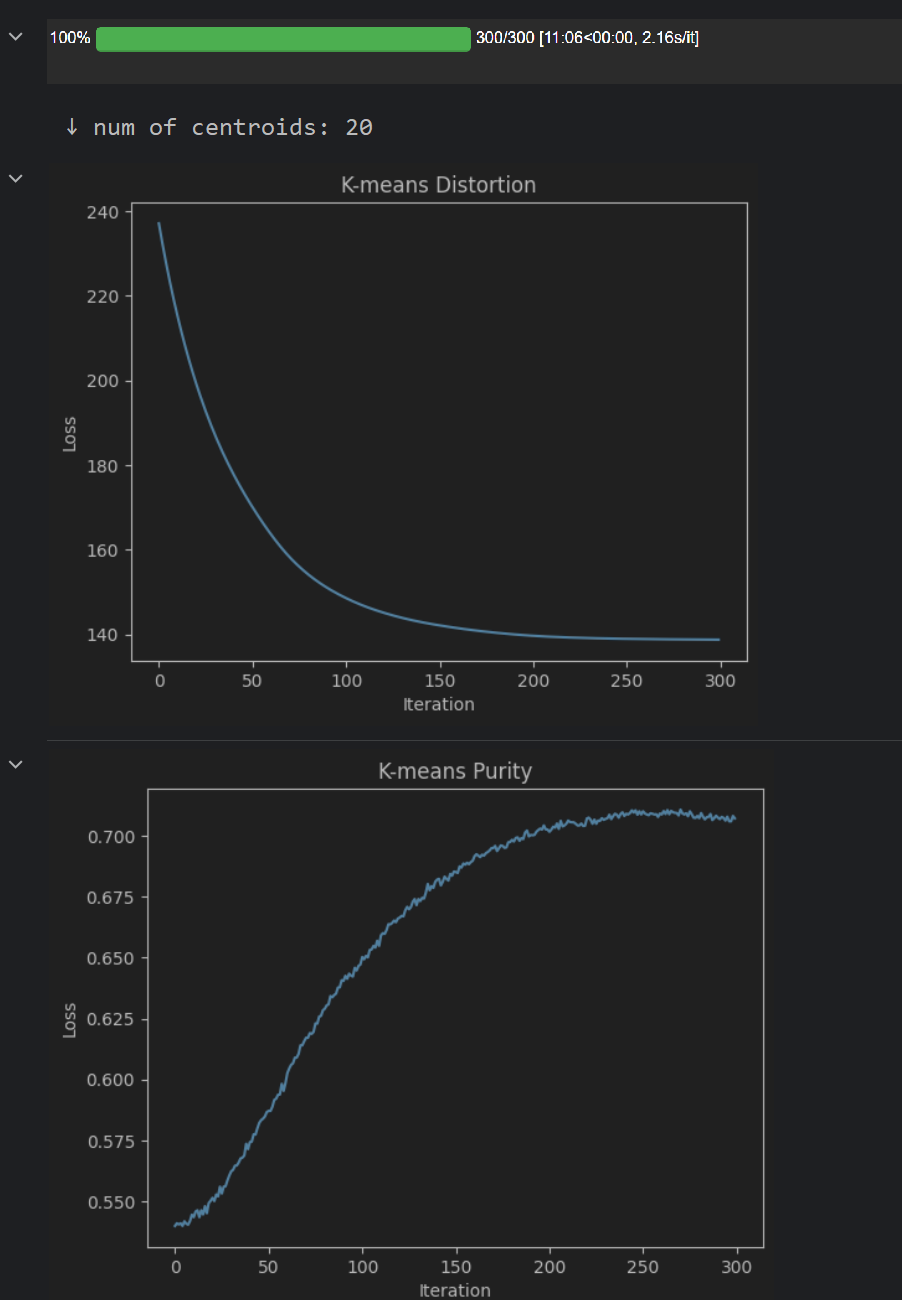

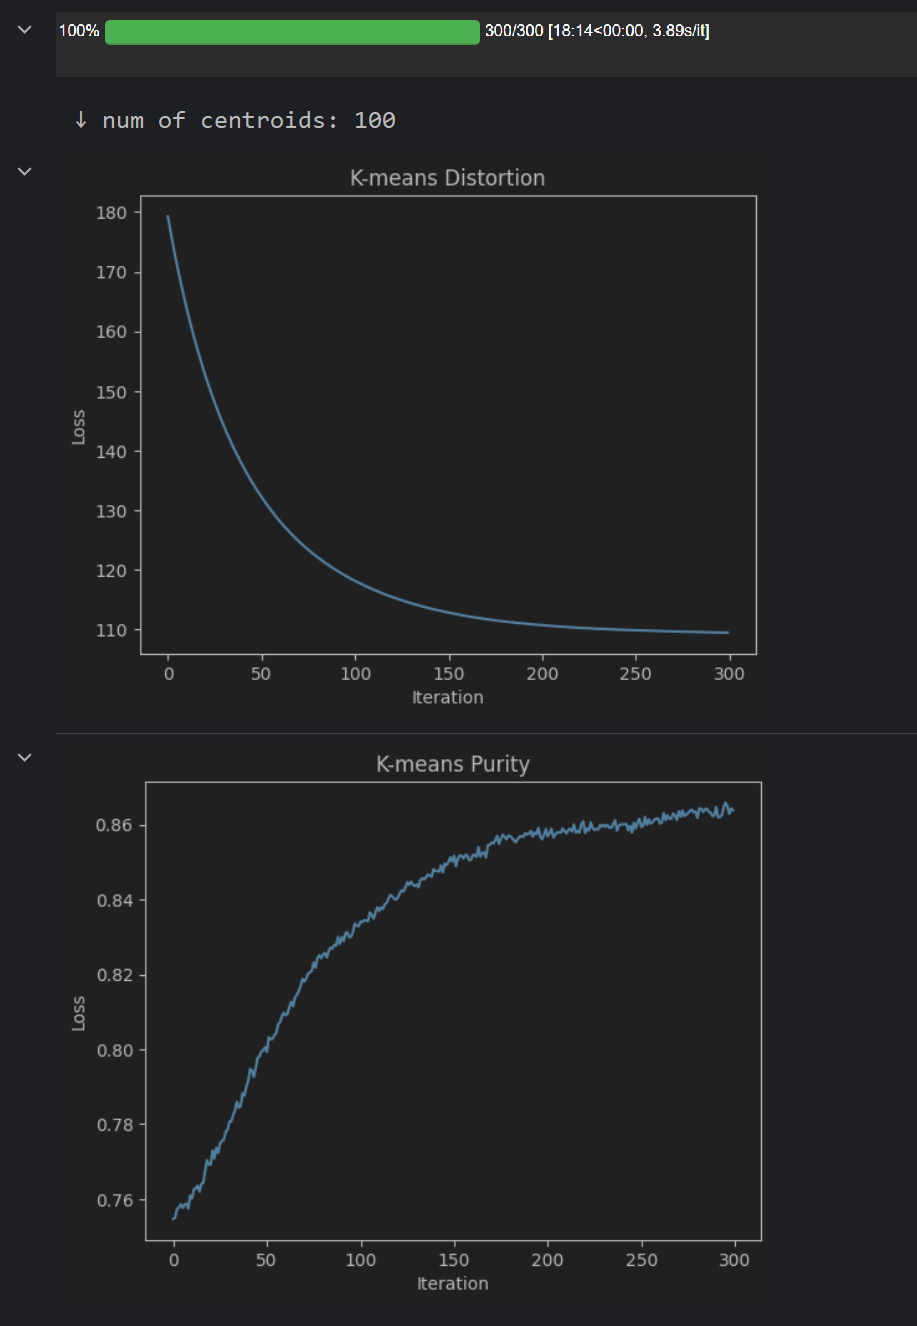


# Ans: Task 3.4(2)

In the above result we can see that:
    visualize_attribute(best_purity_history, name="Purity")

| num of centroids | distortion | purity |
|------------------|------------|--------|
| 3                | 190        | 0.30   |
|10                | 160        | 0.59   |
|15                | 150        | 0.68   |
|20                | 140        | 0.71   |
|100               | 110        | 0.86   |

As the number of centroids grows, distortion dropps down and purity grows up, which is in line with the question's expression.


The reason is that, at low number of centroids, we allow greater errors because the clusters are 'general and wide', thus errors are larger and natually similar digits like '8' and '3' or '1' and '7' are more likely to be in the same cluster. 


However, as the number of centroids grows larger, the errors have to be smaller because the clusters are 'thin and precise'. We focus more on the very detailed differences of these digit patterns and those for the same digit are thus more likely to be split into multiple clusters. As the dataset is limited, over-emphasizing very detailed information of it does not match the data outside the dataset anymore, which therefore leads to overfitting.

The extreme case is that num_of_clusters==n, where every image is uniquely classified and the distortion is 0 while the purity is 1, but we are not really classifying anything and the model is overfitted.

We keep the oracle being 0 is that the image themselves are from 10 classes, which is a fact and is in line with our desired result. We train this model because we want it to fit real-world data outside the training set, which are also really from the same 10 class. We can also conclude that 'distortion' and 'purity' are generally not perfect metrics for evaluating clustering methods.

